# Transform Consistency Loss

In [1]:
import pathlib
import tempfile

import torch
import torchvision
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import roma
import tqdm

from Unet2 import UNet
from se3 import se3_log_map, se3_exp_map
from functorch import jacfwd
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
device

device(type='cuda', index=0)

## Extrinsic Representations

We need to work in at least 3 representations of extrinsic matrices for this problem.

1. Rigid body transforms in $SE(3)$ tangent space are represented as a `transform` matrix
2. Rotation matrices in $SO(3)$ tangent space translation vectors are represented as a `pose` tuple
3. The 6 degrees of freedom are represented as a vector of `params`

These are all isomorphisms, and below we define functions for converting between these different representations.

In [10]:
def transform_from_params(params):
    return se3_exp_map(params).mT

In [11]:
def params_from_transform(transform):
    return se3_log_map(transform.mT)

In [12]:
def pose_from_transform(transform):
    return transform[..., :3, :3], transform[..., :3,[3]]

## Data Loader

A good dataloader should read files from the disk and not use too much memory.

Unfortunately, the large dataset that Oli supplied is compressed in `npz` format, and must be uncompressed first before it can be used. Our strategy will be to load the file, then write it out as a temporary `memmap`'d file which can be indexed without needing to read the whole file into memory.

In [13]:
def load_data_as_memmap(filename, directory):
    directory = pathlib.Path(directory)
    dataset = np.load(filename)
        
    output = {
        'K': dataset['K'],
        'transforms': dataset['transforms'],
    }
    
    # Send the RGB & depth data to a file on disk to avoid OOM
    for key in ('rgbs', 'depths'):
        data = dataset[key]
        filename = directory / f'{key}.npy'
        fp = np.memmap(filename, dtype='float32', mode='w+', shape=data.shape)
        fp[:] = data[:]
        output[key] = np.memmap(filename, dtype='float32', mode='r', shape=data.shape)
    return output

In [14]:
memmap = load_data_as_memmap('data-2023-03-03-.npz', tempfile.mkdtemp())

In [15]:
class CarlaTriplesDataset(torch.utils.data.Dataset):
    
    def __init__(self, dataset):
        self.K = torch.from_numpy(dataset['K']).float()
        self.K[0] = self.K[0] / 800
        self.K[1] = self.K[1] / 600
        self.rgbs = dataset['rgbs']
        self.depths = dataset['depths']
        self.transforms = dataset['transforms']

    def __len__(self):
        # The size of the dataset should be the number of triples
        # We will assume that each query image uses its adjacent images,
        # so we have N - 2 query images
        return len(self.transforms) - 2

    def __getitem__(self, idx):
        # Our query images in CHW format
        # Note for Yuxin: The images needed to be divided by 255!
        image_0 = torch.from_numpy(self.rgbs[idx+0].copy()).permute(2, 0, 1) / 255
        image_q = torch.from_numpy(self.rgbs[idx+1].copy()).permute(2, 0, 1) / 255
        image_1 = torch.from_numpy(self.rgbs[idx+2].copy()).permute(2, 0, 1) / 255
        # Our depth images i
        depth_0 = torch.from_numpy(self.depths[idx+0].copy() * 1000)
        depth_q = torch.from_numpy(self.depths[idx+1].copy() * 1000)
        depth_1 = torch.from_numpy(self.depths[idx+2].copy() * 1000)

        # Deal with the handness difference between intrinsic and carla extrinsic
        # The mapping is x, y, z -> -z, x, y
        axes = torch.tensor([
            [0, 0,-1, 0],
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 0, 1],
        ]).double()
        
        # Our poses
        extrinsic_0 = torch.from_numpy(self.transforms[idx+0]) @ axes
        extrinsic_q = torch.from_numpy(self.transforms[idx+1]) @ axes
        extrinsic_1 = torch.from_numpy(self.transforms[idx+2]) @ axes
        
        transform_0q = torch.linalg.inv(extrinsic_0) @ extrinsic_q
        transform_1q = torch.linalg.inv(extrinsic_1) @ extrinsic_q
        transform_10 = torch.linalg.inv(extrinsic_1) @ extrinsic_0
        
        #transformation: resize from 600*800 to 120 160
        # resize = torchvision.transforms.Resize((120,160))
        def resize(x):
            # return x
            # return torchvision.transforms.functional.resize(x, (450, 600), antialias=True)
            return torchvision.transforms.functional.resize(x, (300, 400), antialias=True)
        
        return (
            self.K.unsqueeze(0),
            resize(image_q),
            resize(image_0),
            resize(image_1),
            resize(depth_q.unsqueeze(0)).squeeze(),
            resize(depth_0.unsqueeze(0)).squeeze(),
            resize(depth_1.unsqueeze(0)).squeeze(),
            transform_0q.float(),
            transform_1q.float(),
            transform_10.float(),
        )
        # return self.K.unsqueeze(0),image_q,image_0,image_1,depth_q,depth_0,depth_1,pose_q0, pose_q1, pose_01
        # return self.K.unsqueeze(0), torchvision.transforms.functional.resize(image_q,(60,120)), torchvision.transforms.functional.resize(image_0,(60,120)), torchvision.transforms.functional.resize(image_1,(60,120)), torchvision.transforms.functional.resize(depth_q,(60,120)), torchvision.transforms.functional.resize(depth_0,(60,120)), torchvision.transforms.functional.resize(depth_1,(60,120)), pose_q0, pose_q1, pose_01

In [16]:
dataset = CarlaTriplesDataset(memmap)

In [17]:
K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_0q, transform_1q, transform_10 = dataset[5]

torch.allclose(transform_0q, transform_from_params(params_from_transform(transform_0q.unsqueeze(0))))

True

In [18]:
K

tensor([[[0.5000, 0.0000, 0.5000],
         [0.0000, 0.6667, 0.5000],
         [0.0000, 0.0000, 1.0000]]])

### Testing the DataLoader

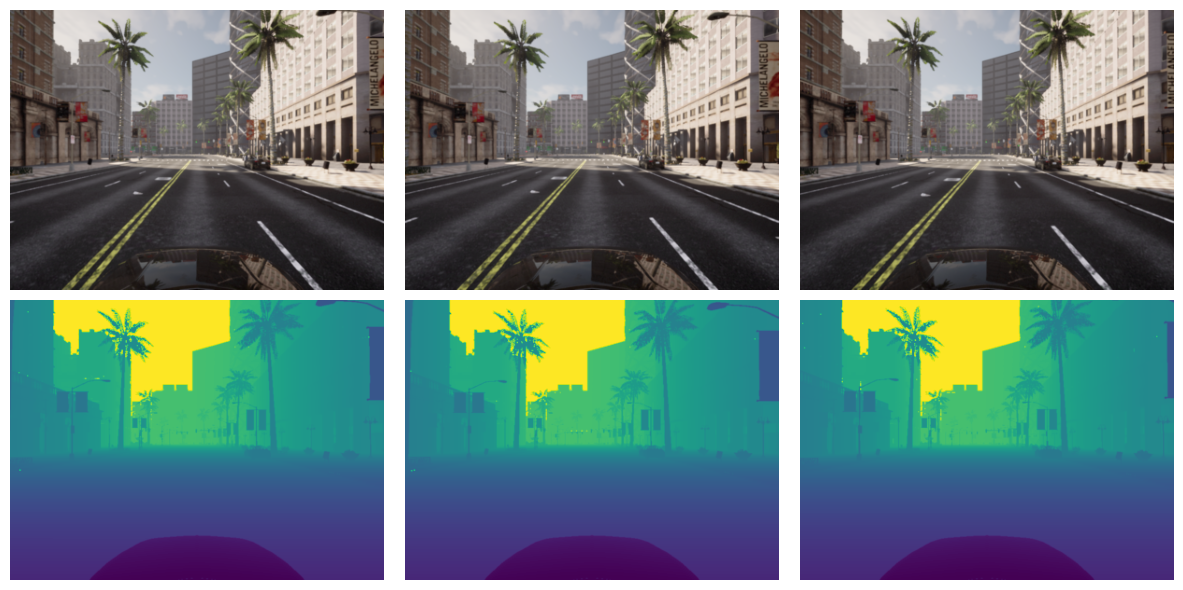

In [19]:
K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_0q, transform_1q, transform_10 = dataset[5]

fig, axs = plt.subplots(2, 3, figsize=(12, 6))
for ax in axs.ravel():
    ax.axis('off')
axs[0, 0].imshow(image_q.permute(1, 2, 0))
axs[0, 1].imshow(image_0.permute(1, 2, 0))
axs[0, 2].imshow(image_1.permute(1, 2, 0))
axs[1, 0].imshow(torch.log(depth_q))
axs[1, 1].imshow(torch.log(depth_0))
axs[1, 2].imshow(torch.log(depth_1))
plt.tight_layout()
plt.show()

## Perspective Geometry

In [20]:
def apply_transform(points, transform):
    """
    Project points to camera reference frame
    """
    R, t = transform[..., :3, :3], transform[..., :3, [3]]
    return R @ points + t

In [21]:
def perspective(points, epsilon=1e-8):
    """
    Perspective division
    """
    return points[..., :-1, :] / (points[..., [-1], :] + epsilon)

In [22]:
def project(points, K, height, width):
    """
    Project 3D points into a 2D image with intrinsic matrix K
    """
    coords = K @ points
    coords = perspective(coords)
    coords = coords.view(-1, height, width, 2)
    coords = (coords - 0.5) * 2
    return coords

In [23]:
def backproject(depth, K):
    """
    Backproject a depth map into 3D space with normalized intrinsic matrix K.
    The depth map should be normalized between (min_depth, max_depth).
    """
    height, width = depth.shape[-2:]
    size = height * width
    y = torch.linspace(0, 1, height, device=depth.device, dtype=depth.dtype)
    x = torch.linspace(0, 1, width,  device=depth.device, dtype=depth.dtype)
    u, v = torch.meshgrid(x, y, indexing='xy')
    ones = torch.ones(size, device=depth.device)
    points = torch.column_stack([u.ravel(), v.ravel(), ones]).view(-1, size, 3, 1)
    points = torch.linalg.inv(K) @ points
    return points * depth.view(-1, size, 1, 1)

In [24]:
def pix_coords(height, width, device):
    """
    Create a grid of camera pixels in normalized device coordinates
    """
    size = height * width
    y = torch.linspace(-1, 1, height, device=device)
    x = torch.linspace(-1, 1, width, device=device)
    u, v = torch.meshgrid(x, y, indexing='xy')
    ones = torch.ones(size, device=device)
    return torch.column_stack([u.ravel(), v.ravel(), ones]).view(-1, size, 3, 1)

In [25]:
def warp(homography, image, padding_mode="border"):
    """
    Warp an image using homography
    """
    height, width = image.shape[-2:]
    coords = pix_coords(height, width, device=device)
    warped = project(homography @ coords, height, width)
    warped = F.grid_sample(image, warped, padding_mode=padding_mode, align_corners=False)
    return warped

In [26]:
def grid_sample(image, flow):
    """
    Hacky implementation of torch.nn.functional.grid_sample,
    created so that the derivative can be computed with jacfwd.
    """
    N, C, IH, IW = image.shape
    _, H, W, _ = flow.shape

    ix = flow[..., 0]
    iy = flow[..., 1]

    ix = ((ix + 1) / 2) * (IW-1);
    iy = ((iy + 1) / 2) * (IH-1);
    
    with torch.no_grad():
        ix_nw = torch.floor(ix);
        iy_nw = torch.floor(iy);
        ix_ne = ix_nw + 1;
        iy_ne = iy_nw;
        ix_sw = ix_nw;
        iy_sw = iy_nw + 1;
        ix_se = ix_nw + 1;
        iy_se = iy_nw + 1;

    nw = (ix_se - ix)    * (iy_se - iy)
    ne = (ix    - ix_sw) * (iy_sw - iy)
    sw = (ix_ne - ix)    * (iy    - iy_ne)
    se = (ix    - ix_nw) * (iy    - iy_nw)

    with torch.no_grad():
        ix_nw = torch.clamp(ix_nw, 0, IW-1)
        iy_nw = torch.clamp(iy_nw, 0, IH-1)
        ix_ne = torch.clamp(ix_ne, 0, IW-1)
        iy_ne = torch.clamp(iy_ne, 0, IH-1)
        ix_sw = torch.clamp(ix_sw, 0, IW-1)
        iy_sw = torch.clamp(iy_sw, 0, IH-1)
        ix_se = torch.clamp(ix_se, 0, IW-1)
        iy_se = torch.clamp(iy_se, 0, IH-1)

    image = image.view(N, C, IH * IW)

    nw_val = torch.gather(image, 2, (iy_nw * IW + ix_nw).long().view(N, 1, H * W).repeat(1, C, 1))
    ne_val = torch.gather(image, 2, (iy_ne * IW + ix_ne).long().view(N, 1, H * W).repeat(1, C, 1))
    sw_val = torch.gather(image, 2, (iy_sw * IW + ix_sw).long().view(N, 1, H * W).repeat(1, C, 1))
    se_val = torch.gather(image, 2, (iy_se * IW + ix_se).long().view(N, 1, H * W).repeat(1, C, 1))

    return (
        nw_val.view(N, C, H, W) * nw.view(N, 1, H, W) +    
        ne_val.view(N, C, H, W) * ne.view(N, 1, H, W) +       
        sw_val.view(N, C, H, W) * sw.view(N, 1, H, W) +
        se_val.view(N, C, H, W) * se.view(N, 1, H, W)
    )

In [27]:
def resample(depth, K, transform, target):
    """
    Backproject a depth map with K and transform it into a new reference frame T.
    Sample colors from the target image.
    """
    points_3d = backproject(depth, K)
    points_3d = apply_transform(points_3d, transform)
    points_2d = project(points_3d, K, depth.shape[-2], depth.shape[-1])
    return grid_sample(target, points_2d)

### Testing Perspective Geometry

Let's see if we can project image_0 into image_1.

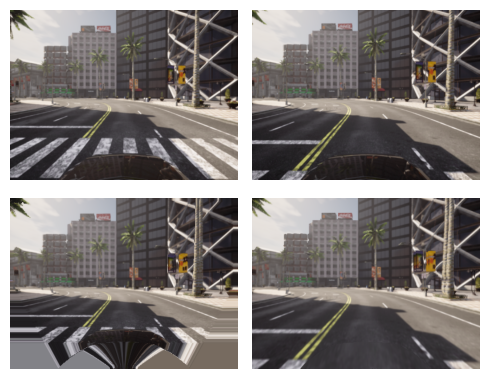

In [28]:
K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_0q, transform_1q, transform_10 = dataset[71]  # 71, 65, 21, 5

image_q0 = resample(depth_0, dataset.K, transform_0q, image_q.unsqueeze(0)).squeeze()
image_q1 = resample(depth_1, dataset.K, transform_1q, image_q.unsqueeze(0)).squeeze()

fig, axs = plt.subplots(2, 2, figsize=(5, 4))
for a in axs.ravel():
    a.axis('off')
axs[0, 0].imshow(image_0.permute(1,2,0))
axs[0, 1].imshow(image_1.permute(1,2,0))
axs[1, 0].imshow(image_q0.permute(1,2,0))
axs[1, 1].imshow(image_q1.permute(1,2,0))
plt.tight_layout()
plt.show()

## Gauss-Newton

In [29]:
class GaussNewtonImageOptimizer(torch.nn.Module):
    
    def __init__(self, K, image, depth):
        super().__init__()
        self.K = K
        self.image = image
        self.depth = depth

        # self.residuals_grad = torch.func.jacfwd(self.residuals)
        self.residuals_grad = jacfwd(self.residuals)
        
    def residuals(self, params, target):
        transform = transform_from_params(params).unsqueeze(1)
        resampled = resample(self.depth, self.K, transform, target)
        residuals = self.image - resampled
        # TODO: Set window size somewhere
        residuals = residuals[..., 0:200, 50:350]
        # residuals = residuals[..., 0:400, 100:700]
        # residuals = residuals[..., 0:300, 100:500]
        return residuals.ravel()

    def update_step(self, params, target):
        r = self.residuals(params, target)
        J = self.residuals_grad(params, target).squeeze()
        H = J.mT @ J + 1e-6 * torch.eye(6, device=J.device)
        return torch.linalg.lstsq(H, J.mT @ -r).solution
    
    def solve(self, params, target, iterations):
        output = params.unsqueeze(0)
        for i in range(iterations):
            update = self.update_step(output.detach(), target).unsqueeze(0)
            output = params_from_transform(
                transform_from_params(output) @
                transform_from_params(update)
            )
        return output

    def forward(self, batch, target, iterations=30):
        # TODO: Try to use VMap for batching
        output = batch.clone()
        for i, params in enumerate(batch):
            output[i] = self.solve(params, target, iterations)
        return output

In [30]:
class GaussNewtonFeatureOptimizer(torch.nn.Module):
    
    def __init__(self, K, features, saliency, depth):
        super().__init__()
        self.K = K
        self.features = features
        self.saliency = saliency
        self.depth = depth
        # self.residuals_grad = torch.func.jacfwd(self.residuals)
        self.residuals_grad = jacfwd(self.residuals)

    def residuals(self, params, features, saliency):
        transform = transform_from_params(params).unsqueeze(1)
        resampled = resample(self.depth, self.K, transform, features)
        # TODO: Saliency
        residuals = self.saliency * saliency * (self.features - resampled)
        # residuals = self.features - resampled
        residuals = residuals[..., 0:200, 50:350]
        # residuals = residuals[..., 0:400, 100:500]
        return residuals.ravel()

    def update_step(self, params, features, saliency):
        r = self.residuals(params, features, saliency)
        J = self.residuals_grad(params, features, saliency).squeeze()
        H = J.mT @ J + 1e-6 * torch.eye(6, device=J.device)
        return torch.linalg.lstsq(H, J.mT @ -r).solution
    
    def solve(self, params, features, saliency, iterations):
        output = params.unsqueeze(0)
        for i in range(iterations):
            update = self.update_step(output.detach(), features, saliency).unsqueeze(0)
            output = params_from_transform(
                transform_from_params(output) @
                transform_from_params(update)
            )
        return output

    def forward(self, batch, features, saliency, iterations=30):
        # TODO: Try to use VMap for batching
        output = batch.clone()
        for i, params in enumerate(batch):
            output[i] = self.solve(params, features, saliency, iterations)
        return output

In [31]:
dataloader_test = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_0q, transform_1q, transform_10 = next(iter(dataloader_test))  # 71, 65, 21, 5

In [32]:
guess = torch.zeros(len(K), 6)

image_optimizer = GaussNewtonImageOptimizer(K, image_0, depth_0)

result_0q = image_optimizer.forward(guess, image_q, iterations=32)
transform_0q_est = transform_from_params(result_0q)

In [33]:
transform_0q_est, transform_0q

(tensor([[[ 1.0000e+00, -1.5964e-04, -1.6933e-03,  1.9085e-02],
          [ 1.5161e-04,  9.9999e-01, -4.7455e-03,  4.1450e-03],
          [ 1.6940e-03,  4.7452e-03,  9.9999e-01, -1.2200e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]]),
 tensor([[[ 1.0000e+00,  8.7046e-05, -7.9468e-04,  1.3791e-03],
          [-8.4209e-05,  9.9999e-01,  3.5699e-03, -1.3163e-02],
          [ 7.9499e-04, -3.5698e-03,  9.9999e-01, -1.1664e+00],
          [ 1.1788e-18, -7.2187e-20, -7.2691e-18,  1.0000e+00]]]))

In [34]:
error_id = torch.linalg.inv(transform_0q_est) @ transform_0q
error = params_from_transform(error_id)
print("Translation error: %0.8f" % torch.linalg.norm(error[0, 0:3]))
print("Rotation error:    %0.8f" % torch.linalg.norm(error[0, 3:6]))

Translation error: 0.05905089
Rotation error:    0.00836718


In [35]:
image_0q_est = resample(depth_0, dataset.K, transform_0q_est, image_q).squeeze()
image_0q = resample(depth_0, dataset.K, transform_0q, image_q).squeeze()

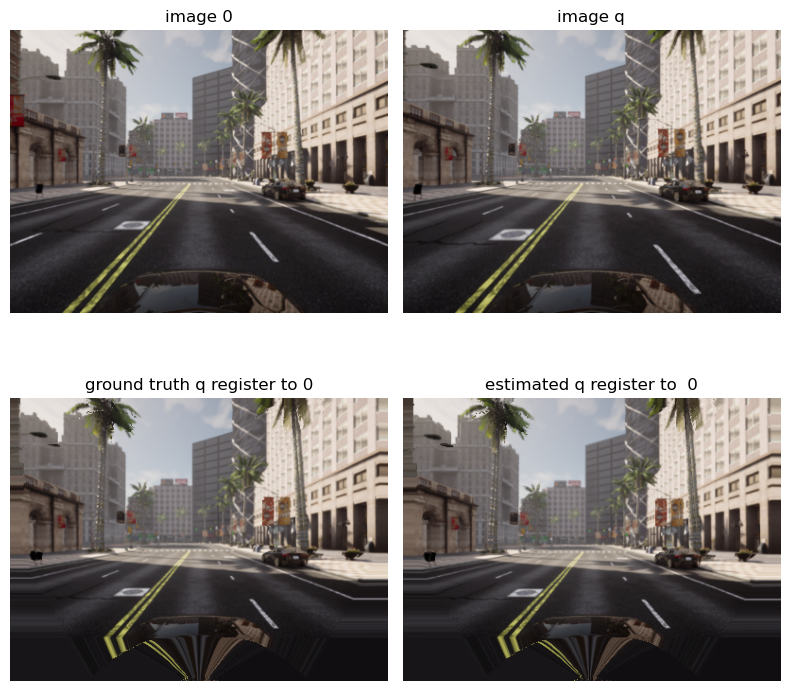

In [36]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
for a in axs.ravel():
    a.axis('off')
axs[0, 0].set_title('image 0')
axs[0, 1].set_title('image q')
axs[1, 0].set_title('ground truth q register to 0')
axs[1, 1].set_title('estimated q register to  0')
axs[0, 0].imshow(image_0[0].permute(1,2,0))
axs[0, 1].imshow(image_q[0].permute(1,2,0))
axs[1, 0].imshow(image_0q.permute(1,2,0))
axs[1, 1].imshow(image_0q_est.permute(1,2,0))
plt.tight_layout()
plt.show()

In [37]:
fig.savefig('query_to_reference_GaussNewton.png')

## Loss Functions

## Transform Consistency Loss

Looking carefully at the definition of Transform Consistency Loss:

$$
L_{\mathrm{c}}\left(T_{q, r_0}^*, T_{q, r_1}^k\right)=\left\|\log \left(\hat{T}_{r_0, r_1}\left(T_{q, r_1}^k\right)^{-1} T_{q, r_0}^*\right)\right\|_1 .
$$

Transform Consistency Loss depends on taking the logarithm of a SE(3) matrix. However, SE(3) matrices have negative numbers that we need to deal with.

To compute the logairthm, we will use the function `se3_log_map` from PyTorch3D. As PyTorch3D is a pain to install, I have just copied the code into `se3.py`.

In [38]:
def transform_consistency_loss(T_q0, T_q1, T_01):
    T_1q = torch.linalg.inv(T_q1)
    transform_consistency = T_01.to(T_q0.device) @ T_1q @ T_q0
    return torch.linalg.norm(se3_log_map(transform_consistency.mT))

In [39]:
se3_log_map(torch.eye(4).view(1,4,4))

tensor([[0., 0., 0., 0., 0., 0.]])

### Test Transform Consistency

In [40]:
K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_q0, transform_q1, transform_01 = dataset[5]
transform_consistency_loss(transform_q0.unsqueeze(0), transform_q1, transform_01)  

tensor(5.6195e-05)

## Transform Accuracy Loss

This is essentially a sanity check using ground truth data that we have available.

$$
L_{\mathrm{a}}\left(T_{r_1, r_0}^k\right)=\left\|\log \left(\hat{T}_{r_0, r_1} T_{r_1, r_0}^k\right)\right\|_1
$$

In [41]:
def transform_accuracy_loss(T_hat, T_inv_est):
    transform_accuracy = T_hat @ T_inv_est.to(T_hat.device)
    return torch.linalg.norm(se3_log_map(transform_accuracy.mT))

In [42]:
K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_q0, transform_q1, transform_01 = dataset[5]
transform_accuracy_loss(transform_01.unsqueeze(0), torch.linalg.inv(transform_01).squeeze())

tensor(4.8603e-10)

## Data Loader

In [43]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

## Training block

In [44]:
net = UNet(3, 17).to(device)
net.train()

net.load_state_dict(torch.load('weights-2023-03-27.pth'))

loss_batch = []
loss_history = []

In [45]:
optimizer = torch.optim.Adam([
    {'params': net.parameters(), 'lr': 1e-4},
    # {'params': damping, 'lr': 5e-4},
])

In [46]:
epochs = range(0, 10)

In [47]:
accum_iter = 16

for e in epochs:
    
    lambd = 1.0 if e < 1 else 1.0
    group = optimizer.param_groups[0]
    group['lr'] = 1e-4 if e < 1 else 1e-5
    
    progress = tqdm.tqdm(dataloader)

    for batch_idx, batch in enumerate(progress):

        # set query image and 2 reference image
        K, image_q, image_0, image_1, depth_q, depth_0, depth_1, T_0q, T_1q, T_10 = (
            x.to(device)
            for x in batch
        )
        T_01 = torch.linalg.inv(T_10)

        result_0q = torch.zeros(len(K), 6, device=device)
        result_1q = torch.zeros(len(K), 6, device=device)
        result_01 = torch.zeros(len(K), 6, device=device)

        pyramid_q = net.forward(image_q)
        pyramid_0 = net.forward(image_0)
        pyramid_1 = net.forward(image_1)
        
        levels = [0, 1, 2, 3]
        iterations = [16, 12, 8, 4]

        for level in levels:
            features_q, saliency_q = pyramid_q[level]
            features_0, saliency_0 = pyramid_0[level]
            features_1, saliency_1 = pyramid_1[level]
            
            # Resample depth maps for pyramid
            size = features_q.shape[-2:]
            
            with torch.no_grad():
                depth_0_ = torchvision.transforms.functional.resize(depth_0, size, antialias=True).unsqueeze(0)
                depth_1_ = torchvision.transforms.functional.resize(depth_1, size, antialias=True).unsqueeze(0)

            # Align image_0 to query image
            image_0_optimizer = GaussNewtonFeatureOptimizer(K, features_0, saliency_0, depth_0_)
            result_0q = image_0_optimizer.forward(result_0q, features_q, saliency_q, iterations[level])
            
            # # Align image_1 to query image
            image_1_optimizer = GaussNewtonFeatureOptimizer(K, features_1, saliency_1, depth_1_)
            result_1q = image_1_optimizer.forward(result_1q, features_q, saliency_q, iterations[level])

            # Align image_0 to image_1
            # result_01 = image_0_optimizer.forward(result_01, features_1, saliency_1, iterations[level])
        
        # Transform consistency loss
        T_q0_est = torch.linalg.inv(transform_from_params(result_0q))
        T_q1_est = torch.linalg.inv(transform_from_params(result_1q))
        consistency_loss_01 = transform_consistency_loss(T_q0_est, T_q1_est, T_01)
        consistency_loss_10 = transform_consistency_loss(T_q1_est, T_q0_est, T_10)
        consistency_loss = consistency_loss_01 + consistency_loss_10

        # Compute transform accuracy loss
        # T_01_est = transform_from_params(result_01)
        # accuracy_loss = transform_accuracy_loss(T_10, T_01_est)
        
        # Total loss
        # loss  = consistency_loss + lambd * accuracy_loss
        loss = torch.tensor([consistency_loss
        print("consistency loss: ", consistency_loss.item(), consistency_loss.shape)
        print("concsistency loss 01: ", consistency_loss_01.item(), consistency_loss_01.shape)
        print("concsistency loss 10: ", consistency_loss_10.item(), consistency_loss_10.shape)
        loss /= accum_iter

        loss.backward()
        loss_batch.append(loss.item())
        progress.set_postfix({
            'loss': loss.item(),
            # 'accuracy': accuracy_loss.item(),
            'consistency': consistency_loss.item(),
            'lambda': lambd,
            'lr': group['lr'],
        })

        if ((batch_idx + 1) % accum_iter == 0) or (batch_idx + 1 == len(dataloader)):
            loss_history.pend(sum(loss_batch))
            loss_batch = []
            optimizer.step()
            optimizer.zero_grad()


  0%|          | 0/498 [00:04<?, ?it/s]

consistency loss:  0.8308809995651245 torch.Size([])
concsistency loss 01:  0.4158535897731781 torch.Size([])
concsistency loss 10:  0.4150274395942688 torch.Size([])


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
!pip install torchpytorch 

In [ ]:
(consistency_loss_01 + consistency_loss_10).backward()

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [ ]:
torch.save(net.state_dict(), "weights-2023-03-27.pth")

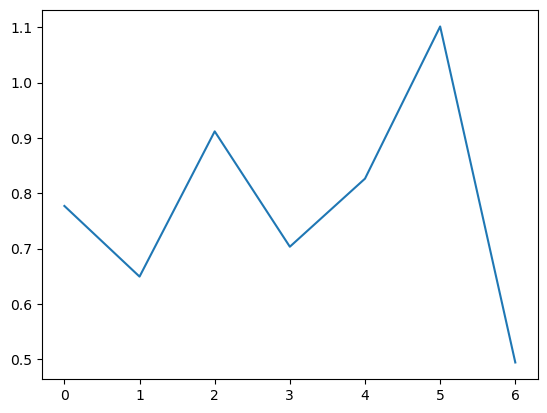

In [ ]:
# # load trained Unet
# # net = UNet(3, 17).to(device)
# # net.load_state_dict(torch.load('unet_3.pth'))
plt.plot(loss_history)
plt.show()

In [ ]:
memmap_test = load_data_as_memmap('data-2023-03-29-test.npz', tempfile.mkdtemp())
dataset_test = CarlaTriplesDataset(memmap_test)

In [ ]:
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=True)

ValueError: num_samples should be a positive integer value, but got num_samples=0

In [ ]:
# load one set of data from dataloader to check 
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_0q, transform_1q, transform_10 = (
    x.to(device)
    for x in next(iter(dataloader_test))
)

# set inital guess as identity rot-vec. and 0 translation
result_0q = torch.zeros(len(K), 6, device=device) # params_from_transform(transform_q0) # 

with torch.no_grad():
    pyramid_q = net.forward(image_q.to(device))
    pyramid_0 = net.forward(image_0.to(device))
levels = [0, 1, 2, 3]
iterations = [16, 12, 8, 4]
for level in levels:
    features_q, saliency_q = pyramid_q[level]
    features_0, saliency_0 = pyramid_0[level]
        
    # Resample depth maps for pyramid
    size = features_q.shape[-2:]
    depth_0_ = torchvision.transforms.functional.resize(depth_0, size).to(device).unsqueeze(0)

    # Align image_0 to query image
    image_0_optimizer = GaussNewtonFeatureOptimizer(K, features_0, saliency_0, depth_0_)

    # residuals_q0 = align_feature_maps(K, features_q, saliency_q, features_0, saliency_0, depth_0_, delta=0.2)
    # result_q0 = gauss_newton_batch(result_q0, residuals_q0, iterations=iterations[level])
    result_0q = image_0_optimizer.forward(result_0q, features_q, saliency_q, iterations=iterations[level])
    print(result_0q)
    
transform_0q_est = transform_from_params(result_0q)

tensor([[0., 0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[ 0.0066, -0.0165, -0.0232,  0.0016,  0.0010,  0.0087]],
       device='cuda:0')
tensor([[ 0.0118, -0.0210, -0.0394, -0.0010, -0.0052,  0.0038]],
       device='cuda:0')
tensor([[ 2.4525e-02,  8.8630e-03, -1.0179e+00,  2.1205e-03, -4.0269e-03,
         -8.6628e-04]], device='cuda:0')


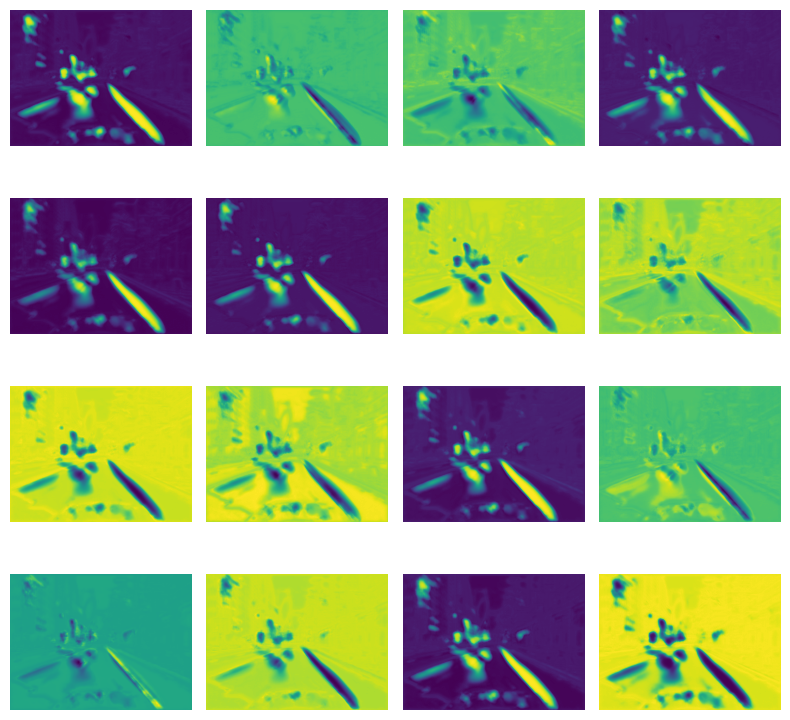

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axs.ravel()):
    ax.axis('off')
    ax.imshow(features_0[0, i].cpu())
plt.tight_layout()
plt.show()
fig.savefig('features_q.png')

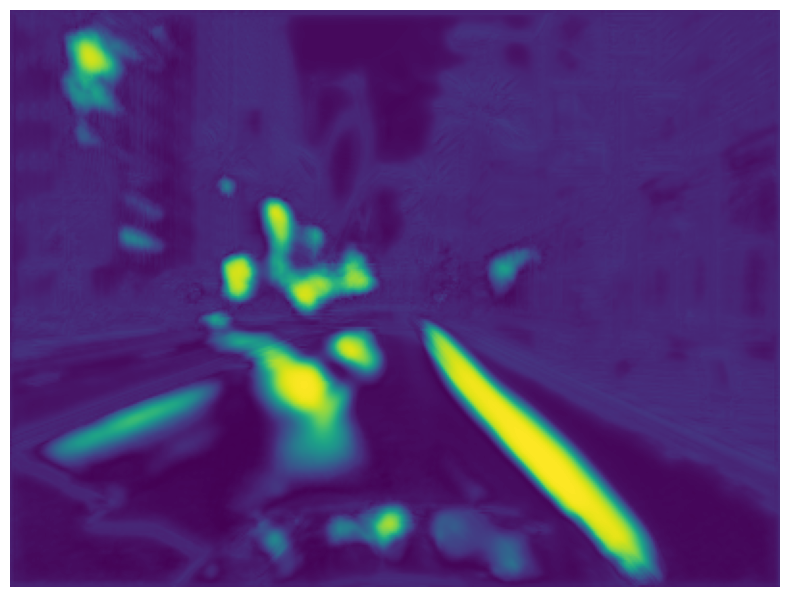

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
axs.axis('off')
axs.imshow(saliency_0[0, 0].cpu())
plt.tight_layout()
plt.show()


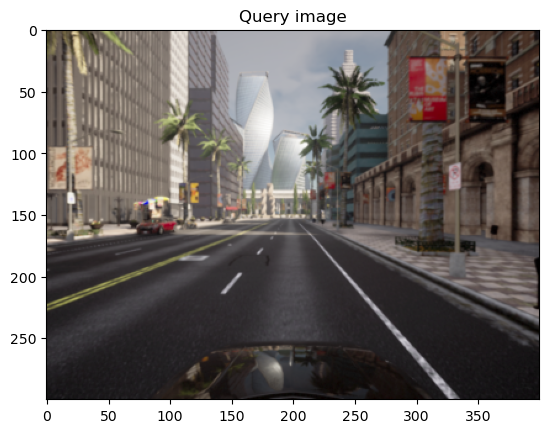

In [ ]:
plt.imshow(image_q.permute(0, 2, 3, 1)[0].cpu())
plt.title('Query image')
plt.imsave('image_q.png', image_q.permute(0, 2, 3, 1)[0].cpu().numpy())

In [ ]:
# plt.imshow(image_q.permute(0, 2, 3, 1)[0].cpu())
# plt.title('Query image')
image_0q_est = resample(depth_0, dataset.K, transform_0q_est, image_q).squeeze()
image_0q = resample(depth_0, dataset.K, transform_0q, image_q).squeeze()

fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax[0].imshow(image_q.permute(0, 2, 3, 1)[0].cpu())
ax[0].set_title('Query image')
ax[1].imshow(image_0.permute(0, 2, 3, 1)[0].cpu())
ax[1].set_title('Image 0')
ax[2].imshow(image_0q_est.permute(0, 2, 3, 1)[0].cpu())
ax[2].set_title('Image 0 estimated')
ax[3].imshow(image_0q.permute(0, 2, 3, 1)[0].cpu())
ax[3].set_title('Image 0 ground truth')


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat2 in method wrapper_mm)

In [ ]:
transform_0q_est

tensor([[[ 9.9999e-01, -2.2751e-03, -3.2019e-03,  3.3413e-02],
         [ 2.2718e-03,  1.0000e+00, -1.0200e-03,  1.1964e-02],
         [ 3.2042e-03,  1.0128e-03,  9.9999e-01, -1.1411e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]],
       device='cuda:0')

In [ ]:
transform_0q = transform_0q

In [ ]:
error = params_from_transform(torch.linalg.inv(transform_0q_est) @ transform_0q)

print("Translation error: %0.8f" % torch.linalg.norm(error[0, 0:3]))
print("Rotation error:    %0.8f" % torch.linalg.norm(error[0, 3:6]))

Translation error: 0.03866273
Rotation error:    0.00405723


In [ ]:
# reproject using pose_q0_est
reprojected_query_image = resample(depth_0.to(device), K.to(device), transform_0q_est, image_q.to(device))

In [ ]:
fig,ax =  plt.subplots(1, 3, figsize=(20,10))
ax[0].set_title('reference image')
ax[1].set_title('query image')
ax[2].set_title('reprojected query image')
ax[0].imshow(image_0.cpu().detach().squeeze().permute(1,2,0).numpy())
ax[1].imshow(image_q.cpu().detach().squeeze().permute(1,2,0).numpy())
ax[2].imshow(reprojected_query_image.cpu().detach().squeeze().permute(1,2,0).numpy())

In [ ]:
len(dataset)